# Serving ML/DL models

This notebook demonstrate how to serve standard ML/DL models using **MLRun Serving**.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](./01-mlrun-basics.html).


MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source "serverless" framework that's focused on data, I/O, and compute-intensive workloads.


MLRun serving supports advanced real-time data processing and model serving pipelines.<br>
For more details and examples, see the {ref}`MLRun serving pipelines <serving>` documentation.

Tutorial steps:
- [**Create, test and build advanced model Serving Graph**](#serving-function)
- [**Deploy the serving Function**](#deploy-serving)

In [1]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="ny-taxi-demo-02", user_project=True, context="./"
)

> 2022-11-21 08:59:03,223 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-21 08:59:03,224 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-21 08:59:03,275 [info] loaded project ny-taxi-demo-02 from MLRun DB


<a id="serving-function"></a>
## Create and test the Serving Function

The serving function kind is using [Nuclio](https://nuclio.io/): a high-performance serverless event 
and data processing open-source platform. With just a few lines of code we can take our model, **expose** it with an **http endpoint** and deploy it on 
**high-performance** infrastructure that can easily scale up to serve on a **production environment** with hundreds of 
thousands of requests per second. To read more about serving functions in MLRun and some cool advanced features like model routers, error handling and more, please refer to our [documentation](https://docs.mlrun.org/en/latest/serving/serving-graph.html).


In [3]:
serving_function = mlrun.code_to_function('serving', filename="src/serving.py", image='mlrun/ml-models', kind="serving")

In [4]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

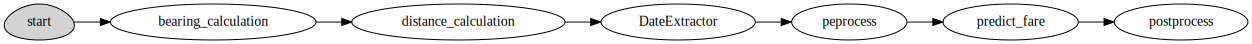

In [5]:
from mlrun.feature_store.steps import DateExtractor
model_server_class = 'mlrun.frameworks.lgbm.LGBMModelServer'
model_uri = project.get_artifact('lgbm_ny_taxi').uri

# Build the serving graph:
graph.to(handler="sphere_dist_bear_step", name="bearing_calculation")\
     .to(handler="sphere_dist_step", name="distance_calculation")\
     .to(DateExtractor(parts=["hour", "day", 'month', "day_of_week", 'year'],timestamp_col="timestamp"))\
     .to(handler="preprocess", name="peprocess")\
     .to(class_name='mlrun.frameworks.lgbm.LGBMModelServer', name="predict_fare", model_path=model_uri)\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [6]:
# registering the serving 
project.set_function(serving_function)
project.save()

In [10]:
# create a mock server (in memory simulator for the graph for testing)
server = serving_function.to_mock_server()

body = {'pickup_longitude':-1.291193, 'pickup_latitude':0.711038,
        'dropoff_longitude':-1.291353, 'dropoff_latitude': 0.710814,
        'passenger_count':1, 'jfk_dist':40.446493, 'ewr_dist':32.342093,
        'lga_dist':21.273835, 'sol_dist':14.063759, 'nyc_dist':5.607925,
        'timestamp': '2013-01-01T12'}

# simulate a user request and print the results
response = server.test(path='/predict', body=body.copy())
print(response)

> 2022-11-21 09:03:11,057 [info] model predict_fare was loaded
predicted fare amount is 7.157547503493431


<a id="deploy-serving"></a>
## Deploy the serving Function


In [8]:
# Deploy it:
serving_function.deploy()

> 2022-11-21 08:59:11,041 [info] Starting remote function deploy
2022-11-21 08:59:11  (info) Deploying function
2022-11-21 08:59:11  (info) Building
2022-11-21 08:59:12  (info) Staging files and preparing base images
2022-11-21 08:59:12  (info) Building processor image
2022-11-21 09:01:47  (info) Build complete
2022-11-21 09:02:25  (info) Function deploy complete
> 2022-11-21 09:02:25,825 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['ny-taxi-demo-02-davesh-serving-ny-taxi-demo-02-davesh.default-tenant.app.yh43.iguazio-cd1.com/']}


'http://ny-taxi-demo-02-davesh-serving-ny-taxi-demo-02-davesh.default-tenant.app.yh43.iguazio-cd1.com/'

In [11]:
response = serving_function.invoke(path='/predict', body=body.copy())
print(response)

> 2022-11-21 09:03:13,995 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-demo-02-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 7.157547503493431'
